# Day 10

In [1]:
from aocd import get_data
from IPython.display import display, Markdown

def answer(x):
    display(Markdown(f"**Answer** = {x}"))

data = get_data(year=2023, day=10)

## Part 1

In [2]:
from inspect import cleandoc

example1 = cleandoc("""
    .....
    .S-7.
    .|.|.
    .L-J.
    .....
""")

example2 = cleandoc("""
    -L|F7
    7S-7|
    L|7||
    -L-J|
    L|-JF
""")

example3 = cleandoc("""
    ..F7.
    .FJ|.
    SJ.L7
    |F--J
    LJ...
""")

example4 = cleandoc("""
    7-F7-
    .FJ|7
    SJLL7
    |F--J
    LJ.LJ
""")

In [3]:
from igraph import Graph
from dataclasses import dataclass
from enum import Enum


@dataclass(frozen=True)
class Point:
    x: int
    y: int

    def __add__(self, other):
        return Point(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Point(self.x - other.x, self.y - other.y)

    def __neg__(self):
        return Point(-self.x, -self.y)


class Direction(Point, Enum):
    N = (0, -1)
    S = (0, 1)
    E = (1, 0)
    W = (-1, 0)

    def __neg__(self):
        return Direction(-self.value)


class Tile(Enum):
    VERTICAL = ("|", {Direction.N, Direction.S})
    HORIZONTAL = ("-", {Direction.E, Direction.W})
    NE_TURN = ("L", {Direction.N, Direction.E})
    NW_TURN = ("J", {Direction.N, Direction.W})
    SW_TURN = ("7", {Direction.S, Direction.W})
    SE_TURN = ("F", {Direction.S, Direction.E})
    START = ("S", set())

    def __new__(cls, value, directions):
        obj = object.__new__(cls)
        obj._value_ = value
        obj.directions = directions
        return obj


@dataclass
class Puzzle:
    tiles: dict[Point, Tile]
    height: int
    width: int

    @classmethod
    def parse(cls, text):
        tiles = {
            Point(x, y): Tile(c)
            for y, line in enumerate(text.split("\n"))
            for x, c in enumerate(line)
            if c != "."
        }
        height = max(point.y for point in tiles) + 1
        width = max(point.x for point in tiles) + 1
    
        return cls(tiles, height, width)

    def starting_point(self):
        return next(p for p, tile in self.tiles.items() if tile == Tile.START)

    def starting_pipe(self):
        (d1, _), (d2, _) = self.starting_steps()
        return next(tile for tile in Tile if tile.directions == {d1, d2})

    def starting_steps(self):
        start = self.starting_point()
        neighbors = {(direction, point) for direction in Direction if (point:=start + direction) in self.tiles}
        return [(direction, point) for direction, point in neighbors if -direction in self.tiles[point].directions]

    def next_step(self, direction, point):
        next_direction = next(iter(self.tiles[point].directions - {-direction}))
        next_point = point + next_direction
        return (next_direction, next_point)

    def farthest_distance(self):
        n1, n2 = self.starting_steps()
        count = 1

        while n1[1] != n2[1]:
            n1 = self.next_step(*n1)
            n2 = self.next_step(*n2)
            count += 1
        return count

    def loop_points(self):
        n1, n2 = self.starting_steps()
        result = {self.starting_point(), n1[1], n2[1]}

        while n1[1] != n2[1]:
            n1 = self.next_step(*n1)
            n2 = self.next_step(*n2)
            result |= {n1[1], n2[1]}
        return result

    def image(self):
        loop_points = self.loop_points()
        return [
            [1 if Point(x, y) in loop_points else 0 for x in range(self.width)]
            for y in range(self.height)
        ]

    def inside_tile_count(self):
        loop_points = self.loop_points()
        result = 0
        for y in range(self.height):
            inside = False
            turn = None
            for x in range(self.width):
                p = Point(x, y)
                if p in loop_points:
                    tile = self.tiles.get(p)
                    if tile == Tile.START:
                        tile = self.starting_pipe()
                    match tile:
                        case Tile.VERTICAL:
                            inside = not inside
                        case Tile.HORIZONTAL:
                            pass
                        case Tile.NE_TURN:
                            turn = Direction.N
                        case Tile.SE_TURN:
                            turn = Direction.S
                        case Tile.NW_TURN if turn == Direction.S:
                            turn = None
                            inside = not inside
                        case Tile.SW_TURN if turn == Direction.N:
                            turn = None
                            inside = not inside
                elif inside:
                    result += 1
        return result

    def inside_image(self):
        OUTSIDE_PIPE_COLOR = [100, 100, 100] # Dark gray
        OUTSIDE_NOTHING_COLOR = [200, 200, 200] # Light gray
        INSIDE_PIPE_COLOR = [100, 50, 0] # Dark orange
        INSIDE_NOTHING_COLOR = [200, 100, 0] # Light orange
        LOOP_COLOR = [255, 255, 0] # Yellow

        loop_points = self.loop_points()

        result = []
        for y in range(self.height):
            inside = False
            turn = None
            line = []
            for x in range(self.width):
                p = Point(x, y)
                if p in loop_points:
                    tile = self.tiles.get(p)
                    if tile == Tile.START:
                        tile = self.starting_pipe()
                    match tile:
                        case Tile.VERTICAL:
                            inside = not inside
                        case Tile.HORIZONTAL:
                            pass
                        case Tile.NE_TURN:
                            turn = Direction.N
                        case Tile.SE_TURN:
                            turn = Direction.S
                        case Tile.NW_TURN if turn == Direction.S:
                            turn = None
                            inside = not inside
                        case Tile.SW_TURN if turn == Direction.N:
                            turn = None
                            inside = not inside
                    line.append(LOOP_COLOR)
                elif inside:
                    if p in self.tiles:
                        line.append(INSIDE_PIPE_COLOR)
                    else:
                        line.append(INSIDE_NOTHING_COLOR)
                else:
                    if p in self.tiles:
                        line.append(OUTSIDE_PIPE_COLOR)
                    else:
                        line.append(OUTSIDE_NOTHING_COLOR)
            result.append(line)
        return result

puzzle4 = Puzzle.parse(example4)
puzzle4.farthest_distance()

8

In [4]:
puzzle = Puzzle.parse(data)
answer(puzzle.farthest_distance())

**Answer** = 6923

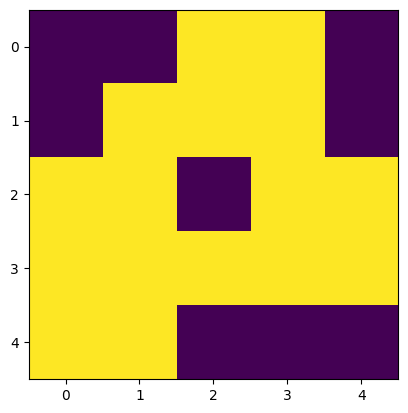

In [5]:
from matplotlib.pyplot import imshow
imshow(puzzle4.image())

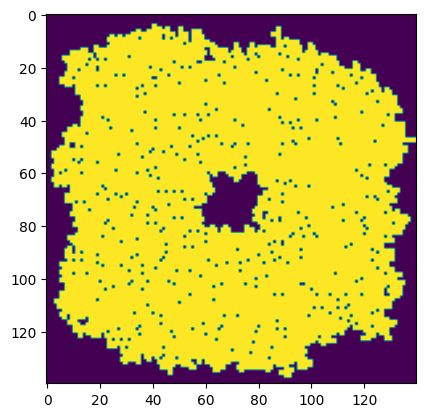

In [6]:
imshow(puzzle.image())

## Part 2

In [7]:
example5 = cleandoc("""
    ...........
    .S-------7.
    .|F-----7|.
    .||.....||.
    .||.....||.
    .|L-7.F-J|.
    .|..|.|..|.
    .L--J.L--J.
    ...........
""")
puzzle5 = Puzzle.parse(example5)

example6 = cleandoc("""
    ..........
    .S------7.
    .|F----7|.
    .||....||.
    .||....||.
    .|L-7F-J|.
    .|..||..|.
    .L--JL--J.
    ..........
""")
puzzle6 = Puzzle.parse(example6)

In [8]:
puzzle4.loop_points()
print(puzzle4.starting_pipe())
puzzle4.inside_tile_count()

Tile.SE_TURN


1

In [9]:
Puzzle.parse(example6).inside_tile_count()

4

In [10]:
answer(Puzzle.parse(data).inside_tile_count())

**Answer** = 529

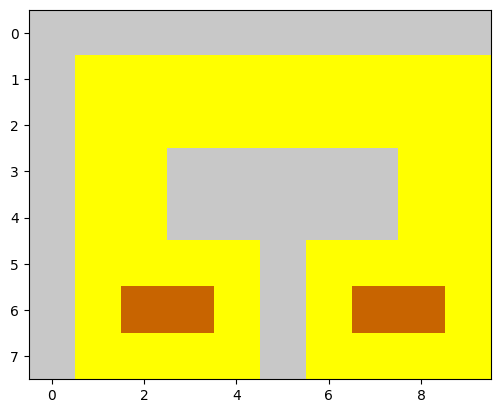

In [11]:
imshow(puzzle5.inside_image())

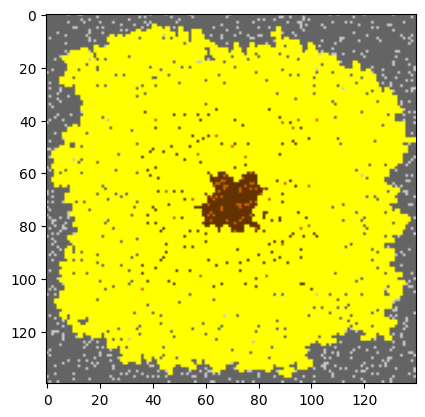

In [12]:
imshow(puzzle.inside_image())